In [1]:
from glob import glob 
import os 

class Config():
    data_path = '/Users/raph/OMIND_SERVER/DATA/rASR Data/'
    raw_files = glob(os.path.join(data_path, 'raw', '*xdf'))
    filtered_files = glob(os.path.join(data_path, 'filtered', '*set'))
    original_asr_out_files = glob(os.path.join(data_path, 'original ASR out', '*set'))
    riemannian_asr_out_files = glob(os.path.join(data_path, 'Riemannian ASR out', '*set'))
    calibration_files = glob(os.path.join(data_path, 'calibration data', '*set'))
    

# Kick-Off Notebook for Rasr implementation 

This notebook is a very crude and straightforward dive into the data provided by Sarah Blum on rASR. It's main purpose is to share with you some useful functions I have already, so that you save some time. 
It consists in: 
- loading the eeg signal (and events?) from the *xdf* and *set* files
- visualizing the power spectral density (check dead channels and line noise) 
- apply a IIR filter using either timeflux node or mne functions 
- apply a rolling window and apply any method from a sklearn estimator 
- leave implementation of rASR as in a sklearn estimator as a TODO thing 
- go back to pandas and plot the pre/post signal  


In [2]:
from collections import OrderedDict

from glob import glob 
import os
import pandas as pd 
import numpy as np 
import mne
import seaborn as sns 
sns.set(font_scale=1)
import matplotlib.pyplot as plt 
%matplotlib notebook

from timeflux.nodes.epoch import Epoch
from timeflux.core.branch import Branch
from pathlib import posixpath

from pyxdf import load_xdf

In [3]:
def get_stream_names(streams, type=None):
    """
        extract stream name from xdf stream
    :param streams: list of dictionnaries
        xdf streams to parse
    :param type: string
        type of stream, eg. 'Signal' or 'Markers'
    :return: list
        list of stream name contained in streams
    """
    if type is None:
        return [stream['info']['name'][0] for stream in streams]
    else:
        return [stream['info']['name'][0] for stream in streams if stream['info']['type'][0] == type]

In [4]:
def extract_signal_stream(streams, name='nexus_signal_raw', channels='all', n = 0):
    """
        extract signal from given stream
    :param streams: list
        streams to be extracted
    :param name: string
        stream name as specified in xdf
    :param channels: string
        if 'all' extract all channels from stream
    :param n: int
        index of stream corresponding to specified stream name
    :return: dataframe
    """
    stream_index = indices(streams, lambda d: d['info']['name'][0] == name)
    if stream_index:
        stream_index = stream_index[n]
        stream = streams[stream_index]

        stream_times = stream['time_stamps']
        stream_values = stream['time_series']
        stream_channels = get_channel_names(stream)

        if (len(stream_times) > 0) & (len(stream_values) > 0):
            if channels == 'all':
                return pd.DataFrame(index=stream_times, data=stream_values, columns=stream_channels)
            else:
                if stream_values is not None:
                    return pd.DataFrame(index=stream_times,
                                data=stream_values[:, [indices(stream_channels, filtr=lambda ch: (ch == channel_name) )[0] for channel_name in channels]], columns=channels)
        else:
            warn("Stream {0} is empty".format(name))
            return pd.DataFrame()
    else:
        warn(name + 'is not in streams.')
        return pd.DataFrame()

In [5]:
def estimate_rate(data):
    """ Estimate nominal sampling rate of a DataFrame.
    This function checks if the index are correct, that is monotonic and regular
    (the jitter should not exceed twice the nominal timespan)
    Notes
    -----
    This function does not take care of jitters in the Index and consider that the rate as the 1/Ts
    where Ts is the average timespan between samples.
    Parameters
    ----------
    data: pd.DataFrame
        DataFrame with index corresponding to timestamp (either DatetimeIndex or floats)
    Returns
    -------
    rate: nominal rate of the DataFrame
    """
    # check that the index is monotonic
    if not data.index.is_monotonic:
        raise DSUException('Data index should be monotonic')
    if data.shape[0] < 2:
        raise DSUException('Sampling rate requires at least 2 points')

    if isinstance(data.index, (pd.TimedeltaIndex, pd.DatetimeIndex)):
        delta = data.index - data.index[0]
        index_diff = np.diff(delta) / np.timedelta64(1, 's')
    elif np.issubdtype(data.index, np.number):
        index_diff = np.diff(data.index)
    else:
        raise DSUException('Dataframe index is not numeric')

    average_timespan = np.median(index_diff)
    if np.any(index_diff >= average_timespan * 2):
        raise DSUException('Effective sampling is greater than twice the nominal rate')

    return 1 / average_timespan


In [6]:
def pandas_to_mne(data, rate, events=None, montage_kind = 'standard_1005', unit_factor = 1e-6, bad_ch= []):
    ''' Convert a pandas Dataframe into mne raw object 
    Parameters
    ----------
    data: Dataframe with index=timestamps, columns=eeg channels
    rate: Sampling rate 
    events: array, shape = (n_events, 3) with labels on the third axis. 
    unit_factor: unit factor to apply to get Voltage
    bad_ch: list of channels to reject 

    Returns
    -------
    raw: raw object
    '''
    n_chan = len(data.columns)

    X = data.copy().values
    times = data.index

    ch_names = list(data.columns)
    ch_types = ['eeg'] * n_chan
    montage = mne.channels.read_montage(montage_kind) if montage_kind is not None else None
    # sfreq = estimate_rate(data)
    X *= unit_factor

    if events is not None:
        events_onsets = events.index
        events_labels = events.label.values
        event_id = {mk: (ii + 1) for ii, mk in enumerate(np.unique(events_labels))}
        ch_names += ['stim']
        ch_types += ['stim']


        trig = np.zeros((len(X), 1))
        for ii, m in enumerate(events_onsets):
            ix_tr = np.argmin(np.abs(times - m))
            trig[ix_tr] = event_id[events_labels[ii]]

        X = np.c_[X, trig]
    else:
        event_id = None

    info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=rate, montage=montage)
    info["bads"] = bad_ch
    raw = mne.io.RawArray(data=X.T, info=info, verbose=False)
    picks =  mne.pick_channels(raw.ch_names, include = [], exclude=["stim"] + bad_ch )
    return raw, event_id, picks

## Raw data 

### Load xdf and extract eeg stream

In [7]:
k_file = 0

In [8]:
from datascience_utils.data_io import get_stream_names, extract_signal_stream
raw_xdf_fname = Config.raw_files[k_file]
streams, _ = load_xdf(raw_xdf_fname)
stream_names = get_stream_names(streams)
df_eeg_raw = extract_signal_stream(streams , 'Android_EEG_010026')
df_presentation_events = extract_signal_stream(streams , 'Presentation_Markers')
df_eeg_raw.head()

,Fp1,Fp2,Fz,F7,F8,FC1,FC2,Cz,C3,C4,...,O1,O2,GyroX,GyroY,GyroZ,AccX,AccY,AccZ,GPSLatitude,GPSLongitude
7497.971543,-16967.007812,-10655.322266,-3959.700928,-9417.929688,-17009.855469,-8716.822266,-9959.065430,-7430.814453,-15642.242188,-8289.144531,...,-6697.856445,-4115.246582,0.49,-3.85,4.34,5.134003,-0.019302,8.444489,53.146729,8.183227
7497.975543,-16968.863281,-10659.859375,-3959.589111,-9420.388672,-16994.410156,-8719.572266,-9956.942383,-7431.909668,-15647.540039,-8287.490234,...,-6693.944824,-4111.983398,0.49,-3.85,4.34,5.134003,-0.043976,8.409637,53.146729,8.183227
7497.979543,-16965.845703,-10649.287109,-3960.550293,-9420.678711,-17014.058594,-8720.756836,-9957.612305,-7431.887695,-15648.322266,-8287.691406,...,-6688.893066,-4108.809570,8.96,-3.85,4.34,5.134003,-0.043976,8.409637,53.146729,8.183227
7497.983543,-16963.566406,-10633.461914,-3960.192627,-9420.723633,-17007.039062,-8721.717773,-9957.679688,-7431.529785,-15649.238281,-8287.557617,...,-6689.004883,-4105.501465,8.96,-5.18,4.34,5.134003,-0.040497,8.375397,53.146729,8.183227
7497.987543,-16962.447266,-10647.767578,-3959.410400,-9419.717773,-17000.490234,-8722.142578,-9958.082031,-7432.133301,-15650.221680,-8287.847656,...,-6693.430664,-4104.205078,8.96,-5.18,3.85,5.145599,-0.050079,8.436356,53.146729,8.183227


In [9]:
# select EEG channels 
eeg_columns = ['Fp1', 'Fp2', 'Fz', 'F7', 'F8', 'FC1', 'FC2', 'Cz', 'C3', 'C4', 'T7',
       'T8', 'CPz', 'CP1', 'CP2', 'CP5', 'CP6', 'Tp9', 'Tp10', 'Pz', 'P3',
       'P4', 'O1', 'O2']
df_eeg_raw = df_eeg_raw.loc[:, eeg_columns]

### Eventually, convert float index in datetime

In [10]:
from datetime import datetime
def time_index_to_float_index(df, inplace=False):
    """Convert a dataframe float indices to `datetime64['us']` indices."""
    if not inplace: 
        df = df.copy()
    df.index = df.index.map(lambda d: d.timestamp())
    return df

def float_index_to_time_index(df, inplace=False):
    """Convert a dataframe float indices to `datetime64['us']` indices."""
    if not inplace: 
        df = df.copy()
    df.index = df.index.map(datetime.utcfromtimestamp)
    df.index = pd.to_datetime(df.index, unit='us', utc=False)
    return df
df_eeg_raw = float_index_to_time_index(df_eeg_raw)

In [11]:
duration = (df_eeg_raw.index[-1] - df_eeg_raw.index[0]).total_seconds()/60
rate = estimate_rate(df_eeg_raw)
print(f'Duration of session was {duration} min. \n '+ 
     f'Rate is of {rate} Hz.')

Duration of session was 21.5832569 min. 
 Rate is of 250.0 Hz.


### Convert from pandas to mne, and eventually filter using timeflux or mne 

In [12]:
#df_eeg_raw = pd.read_hdf(fname, '/eeg/raw') # TODO: adapt hdf5 groups 
# df_events = pd.read_hdf(fname, '/events/speller') # TODO: adapt hdf5 groups 
# baseline_events = df_events[df_events.label.str.contains('baseline')] # TODO: adapt calib times 
# calib_times = baseline_events.index[0], baseline_events.index[-1] # TODO: adapt calib times 


bad_ch = []

mne_eeg_raw, mene_event_id, mne_picks = pandas_to_mne(df_eeg_raw, rate=rate, bad_ch=bad_ch)

# Either filter using mne offline tool (higher order)
# ----------------------------------------------------
mne_eeg_filtered = mne_eeg_raw.copy().filter(1, 30)
df_eeg_filtered = pd.DataFrame(mne_eeg_filtered.to_data_frame().values, 
                               df_eeg_raw.index, df_eeg_raw.columns)


# Or mimick online with timeflux
# ------------------------------
# notch + bandpass in realtime world 
#=======================================================================#
#======= UNCOMMENT THESE LINES TO DO SO ================================#
#from timeflux_dsp.nodes.filters import IIRFilter, IIRLineFilter
## apply a line noise filter
#line = IIRLineFilter(rate=rate, edges_center=(50, 100))
#line.i.data = df_eeg_raw
#line.update()
## apply a bandpass filter 
#bandpass = IIRFilter(rate=rate, order=3, frequencies=[1, 30], filter_type='bandpass')
#bandpass.i.data = line.o.data
#bandpass.update()
# convert dataframe to mne 
#df_eeg_filtered, _, _ = pandas_to_mne(bandpass.o.data, sfreq=rate, bad_ch=bad_ch)
#=======================================================================#

/miniconda3/envs/timeflux/lib/python3.7/site-packages/mne/utils/docs.py:824: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/miniconda3/envs/timeflux/lib/python3.7/site-packages/mne/utils/docs.py:807: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-6-a405814d4042>:43: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif``, ``read_dig_e

Converting "time" to "<class 'numpy.int64'>"...


### Visualize power spectral density

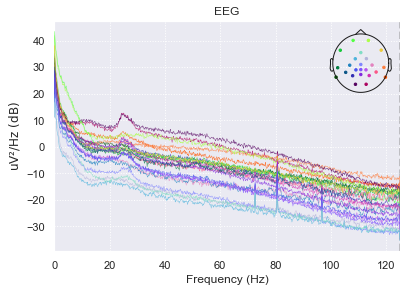

<Figure size 432x288 with 0 Axes>

In [13]:
mne_eeg_raw.plot_psd(); 
plt.suptitle('Raw'); 

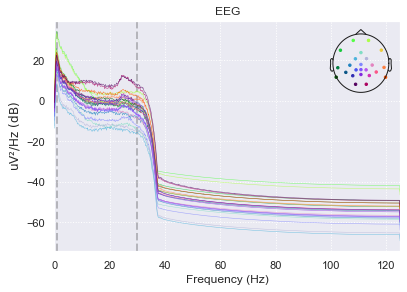

<Figure size 432x288 with 0 Axes>

In [14]:
mne_eeg_filtered.plot_psd(); 
plt.suptitle('Filtered'); 

## Load filtered data 

Reading /Users/raph/OMIND_SERVER/DATA/rASR Data/filtered/sme_1_5.xdf_filt.fdt
Converting "time" to "<class 'numpy.int64'>"...
Effective window size : 8.192 (s)


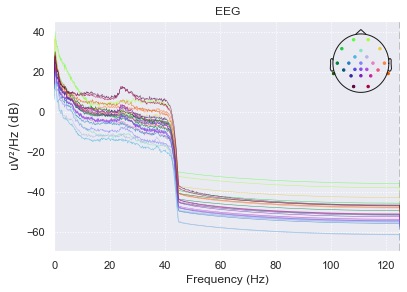

In [15]:
from mne.io import read_raw_eeglab
mne_eeg_filtered =  read_raw_eeglab(Config.filtered_files[k_file])
df_eeg_filtered = mne_eeg_filtered.to_data_frame()
mne_eeg_filtered.plot_psd(); 

# Load calibration data 


Reading /Users/raph/OMIND_SERVER/DATA/rASR Data/calibration data/sme_1_5.xdf_filt.fdt
Converting "time" to "<class 'numpy.int64'>"...


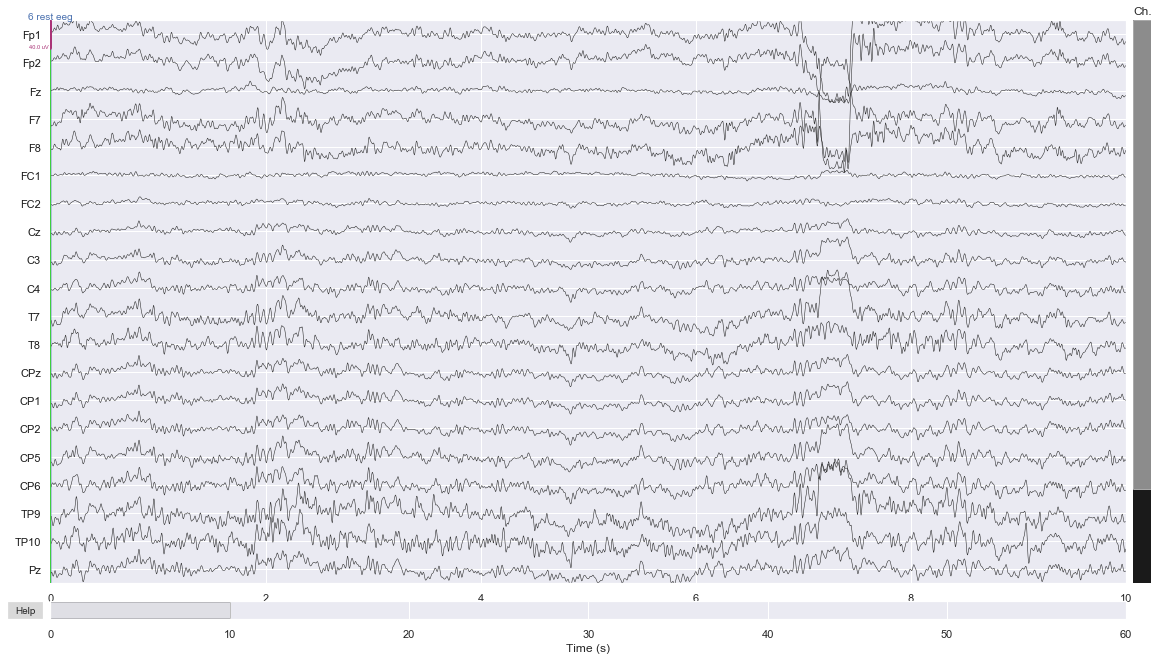

In [16]:
mne_eeg_calibration =  read_raw_eeglab(Config.calibration_files[k_file])
df_eeg_calibration = mne_eeg_calibration.to_data_frame()
mne_eeg_calibration.plot(); 

# Load rASR output 


Reading /Users/raph/OMIND_SERVER/DATA/rASR Data/Riemannian ASR out/sme_1_3.fdt


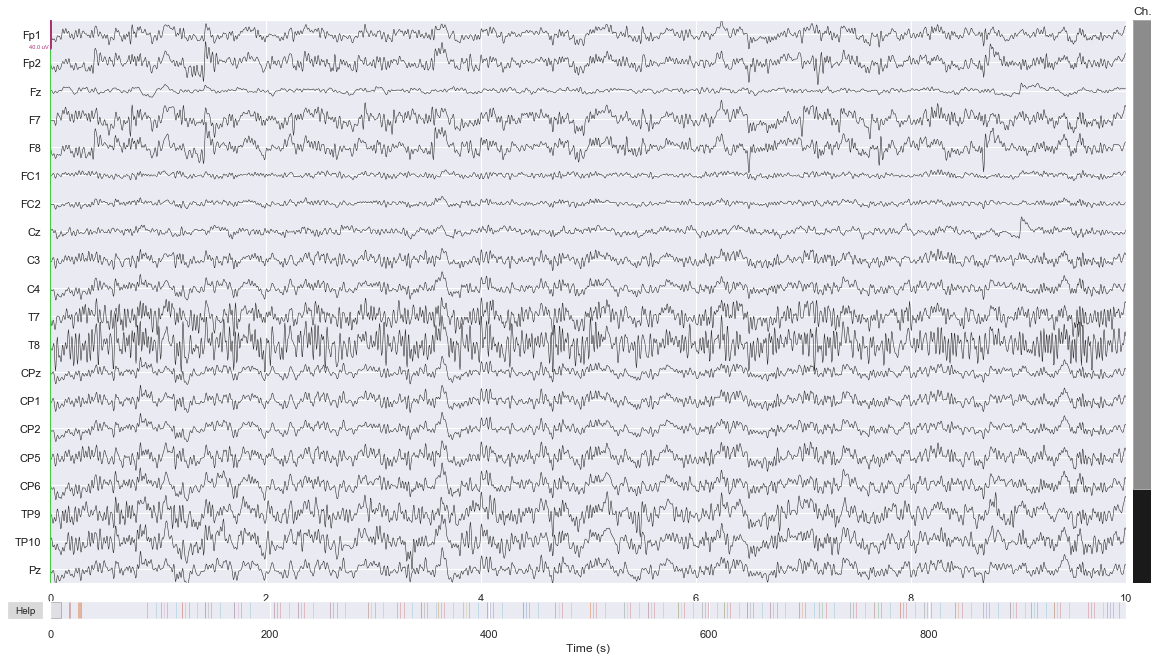

In [17]:
mne_eeg_cleaned =  read_raw_eeglab(Config.riemannian_asr_out_files[k_file])
mne_eeg_cleaned.plot(); 

In [18]:
df_eeg_cleaned = mne_eeg_cleaned.to_data_frame()
df_eeg_cleaned.head()

Converting "time" to "<class 'numpy.int64'>"...


channel,Fp1,Fp2,Fz,F7,F8,FC1,FC2,Cz,C3,C4,...,CP2,CP5,CP6,TP9,TP10,Pz,P3,P4,O1,O2
time,,,,,,,,,,,,,,,,,,,,,
0,-0.013201,-0.018014,-0.002674,-0.014927,-0.020207,-0.004922,-0.005249,0.003866,-0.008218,-0.009376,...,-0.003169,-0.008527,-0.006787,-0.013160,-0.009481,-0.006543,-0.009023,-0.005224,-0.011545,-0.005085
4,-2.149520,-2.997436,0.370554,-2.383737,-3.500363,-0.985134,-1.113579,1.089316,-2.378617,-2.461724,...,-2.277262,-3.182305,-2.891909,-1.720168,2.490218,-3.319987,-3.407804,-3.142468,-4.570573,-4.117846
8,-3.895139,-5.864177,0.539733,-3.178975,-6.947680,-1.263157,-1.854852,2.028313,-3.210253,-4.013163,...,-3.846894,-4.019107,-5.053304,-2.674080,4.502221,-5.507792,-4.718487,-5.463203,-5.167932,-7.430803
12,-5.326047,-8.181021,0.234812,-2.908594,-9.845233,-0.794303,-2.190716,2.798930,-2.408971,-4.549795,...,-4.462390,-2.443428,-6.368649,-4.445235,3.826417,-5.994227,-3.425189,-6.924243,-2.071115,-9.617757
16,-6.644497,-9.594512,-0.669602,-2.639865,-11.759719,0.153404,-2.224215,3.137824,-0.649834,-4.409935,...,-4.330470,0.285214,-6.976540,-8.078924,0.009132,-5.036457,-0.483622,-7.656090,2.468204,-10.303535


# Epoch the data

In [19]:
from numpy.lib import stride_tricks

def epoch(a, size, interval, axis=-1):
    """ Small proof of concept of an epoching function using NumPy strides
    License: BSD-3-Clause
    Copyright: David Ojeda <david.ojeda@gmail.com>, 2018

    Create a view of `a` as (possibly overlapping) epochs.
    The intended use-case for this function is to epoch an array representing
    a multi-channels signal with shape `(n_samples, n_channels)` in order
    to create several smaller views as arrays of size `(size, n_channels)`,
    without copying the input array.
    This function uses a new stride definition in order to produce a view of
    `a` that has shape `(num_epochs, ..., size, ...)`. Dimensions other than
    the one represented by `axis` do not change.
    Parameters
    ----------
    a: array_like
        Input array
    size: int
        Number of elements (i.e. samples) on the epoch.
    interval: int
        Number of elements (i.e. samples) to move for the next epoch.
    axis: int
        Axis of the samples on `a`. For example, if `a` has a shape of
        `(num_observation, num_samples, num_channels)`, then use `axis=1`.
    Returns
    -------
    ndarray
        Epoched view of `a`. Epochs are in the first dimension.
    """
    a = np.asarray(a)
    n_samples = a.shape[axis]
    n_epochs = (n_samples - size) // interval + 1

    new_shape = list(a.shape)
    new_shape[axis] = size
    new_shape = (n_epochs,) + tuple(new_shape)

    new_strides = (a.strides[axis] * interval,) + a.strides

    return stride_tricks.as_strided(a, new_shape, new_strides)


In [20]:
size = int(rate*3) # size of window in samples 
interval = size # step interval in samples 

# convert filtered data into epochs 
np_eeg_filtered_epochs = epoch(df_eeg_filtered.values, size, interval, axis=0)# (n_channels,  n_times, n_trials)
np_eeg_filtered_epochs = np.swapaxes(np_eeg_filtered_epochs, 0, 2 ) # (n_trials, n_channels, n_times)

# convert calibration data into epochs 
np_eeg_calibration_epochs = epoch(df_eeg_calibration.values, size, interval, axis=0)# (n_channels,  n_times, n_trials)
np_eeg_calibration_epochs = np.swapaxes(np_eeg_calibration_epochs, 0, 2 )# (n_trials, n_channels, n_times)


## RASR IMPLEMENTATION 

In [21]:
# Let's say we calibrate on the 20 first epochs and test on the rest 
# TODO : refine this 
X_fit = np_eeg_calibration_epochs
X_test = np_eeg_filtered_epochs

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

class RASR(BaseEstimator, TransformerMixin):
    """ RASR
    Implements this (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6499032/) paper. 
    Matlab code from the author here:  https://github.com/s4rify/rASRMatlab
    
    Attributes
    ----------
    foo : float
        xxxx
    """
    
    def __init__(self, metric='riemann', n_jobs=1):
        """Init."""
        # TODO: 
    
    def partial_fit(self, X, y=None): 
        """
        """
        # TODO if relevent 
        
    def fit(self, X, y=None):
        """ 
        Parameters
        ----------
        X : ndarray, shape (n_trials, n_channels, n_times)
            Training data.
        y : ndarray, shape (n_trials, n_dims) | None, optional
            The regressor(s). Defaults to None.
        Returns
        -------
        X : ndarray, shape (n_trials, n_good_channels, n_times)
            The data without flat channels.
        """
        # TODO; implement that 
        return self

    def transform(self, X):
        """Clean signal 
        Parameters
        ----------
        X : ndarray, shape (n_trials, n_channels, n_times)
            Training data.
        Returns
        -------
        X : ndarray, shape (n_trials, n_good_channels, n_times)
            The data without flat channels.
        """
        # TODO; implement that 
        return X

    def fit_transform(self, X, y=None):
        """Estimate rASR and clean signal 
        Parameters
        ----------
        X : ndarray, shape (n_trials, n_channels, n_times)
            Training data.
        y : ndarray, shape (n_trials, n_dims) | None, optional
            The regressor(s). Defaults to None.
        Returns
        -------
        X : ndarray, shape (n_trials, n_good_channels, n_times)
            The data without flat channels.
        """
        self.fit(X, y)
        return self.transform(X)

# RASR tests

In [23]:
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import Covariances
from pyriemann.channelselection import FlatChannelRemover

rASR_pipeline = make_pipeline(FlatChannelRemover(), RASR())

X_test_transformed = rASR_pipeline.fit(X_fit).transform(X_test)

/miniconda3/envs/timeflux/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


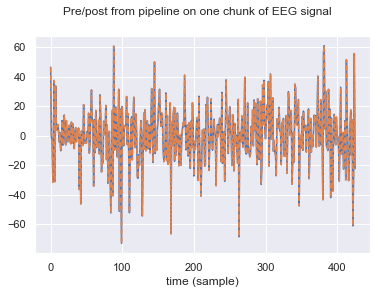

In [24]:
k_ch = 8
k_epoch = 10

plt.figure()
plt.plot(X_test[k_epoch,k_ch,:].T)
plt.plot(X_test_transformed[k_epoch,k_ch,:].T, '--')
plt.suptitle(f'Pre/post from pipeline on one chunk of EEG signal')
plt.xlabel('time (sample)')
plt.show()

## Back to signal 

In [25]:
values = X_test_transformed.reshape(-1, X_test_transformed.shape[0])
df_eeg_cleaned_v2 = pd.DataFrame(values, columns = df_eeg_raw.columns)
df_eeg_cleaned_v2.head()

,Fp1,Fp2,Fz,F7,F8,FC1,FC2,Cz,C3,C4,...,CP2,CP5,CP6,Tp9,Tp10,Pz,P3,P4,O1,O2
0,-24.174801,3.599609,-29.671782,17.976318,-38.624870,14.307739,-135.201385,-92.873749,6.526262,-36.902176,...,-0.812105,-3.765260,13.777680,3.628966,0.701711,8.085481,-0.225752,-11.070732,7.959374,-5.507322
1,-7.555198,5.270411,-10.501235,4.781223,-3.230576,2.058115,-40.718536,-9.614815,5.961645,-44.207825,...,5.389032,-45.044670,37.876457,-3.330570,79.916702,-24.591291,-29.705105,70.553246,-52.488113,4.194554
2,20.070797,-8.052155,76.628960,-27.574015,0.709322,-9.505060,112.531395,71.802650,62.360287,-44.062683,...,109.023315,-42.369198,-49.331547,7.892853,17.077379,48.302387,225.046082,44.144753,-13.485636,-108.035172
3,186.473251,-14.002469,-55.437794,32.849277,140.722946,-61.995483,-61.334988,117.039474,-74.129715,-17.757130,...,-18.955845,-8.276394,-101.274315,-135.253860,-206.028793,34.428040,-58.596230,81.668022,-24.112530,64.646843
4,-186.481766,13.049810,-58.113487,-8.998556,-11.766560,29.341576,-62.598721,36.642605,-76.550636,-44.469131,...,-7.179565,124.368904,57.390743,13.893906,-65.234329,6.634096,-13.852467,-102.131813,-15.039901,-67.371994
